# Importing libraries

In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
import xgboost as xgb
from sklearn.metrics import r2_score

# Loading the data

In [2]:
df = pd.read_csv(r'C:\Users\Abirami\Documents\HomeLLC\Data\CSUSHPISA.csv')

In [3]:
df

,DATE,CSUSHPISA
0,2000-01-01,100.551
1,2000-02-01,101.339
2,2000-03-01,102.127
3,2000-04-01,102.922
4,2000-05-01,103.678
...,...,...
271,2022-08-01,301.473
272,2022-09-01,299.353
273,2022-10-01,298.873
274,2022-11-01,298.269


In [3]:
file_names = ['CSINFT02USM460S', 'CUSR0000SEHA', 'GDP', 'HNFSEPUSSA', 'HOUST1F', 'HSN1F', 'LFACTTTTUSM657S', 'MSNHUS', 
              'MORTGAGE30US', 'NHFSEPCS', 'NHFSEPNTS', 'NHFSEPUCS', 'PERMIT', 'QUSR628BIS', 'RSAHORUSQ156S', 'RHORUSQ156N',
              'TTLCONS', 'UMCSENT', 'UNRATE']

In [4]:
for file_name in file_names:
    globals()[file_name] = pd.read_csv(r'C:\Users\Abirami\Documents\HomeLLC\Data\{}.csv'.format(file_name))
    globals()[file_name]   

MORTGAGE30US column is in weekly format, need to convert it to monthly format for further analysis 

In [5]:
MORTGAGE30US['DATE'] = pd.to_datetime(MORTGAGE30US['DATE'])
MORTGAGE30US.set_index('DATE', inplace=True)
monthly = MORTGAGE30US.resample('M').mean()
monthly['FirstDayOfMonth'] = monthly.index.to_period('M').to_timestamp()
monthly.reset_index(inplace=True)
monthly

,DATE,MORTGAGE30US,FirstDayOfMonth
0,2000-01-31,8.2100,2000-01-01
1,2000-02-29,8.3250,2000-02-01
2,2000-03-31,8.2400,2000-03-01
3,2000-04-30,8.1525,2000-04-01
4,2000-05-31,8.5150,2000-05-01
...,...,...,...
271,2022-08-31,5.2225,2022-08-01
272,2022-09-30,6.1120,2022-09-01
273,2022-10-31,6.9000,2022-10-01
274,2022-11-30,6.8050,2022-11-01


In [6]:
monthly.drop(columns=['DATE'], inplace=True)

In [7]:
monthly.rename(columns={'FirstDayOfMonth':'DATE'}, inplace=True)

In [8]:
monthly

,MORTGAGE30US,DATE
0,8.2100,2000-01-01
1,8.3250,2000-02-01
2,8.2400,2000-03-01
3,8.1525,2000-04-01
4,8.5150,2000-05-01
...,...,...
271,5.2225,2022-08-01
272,6.1120,2022-09-01
273,6.9000,2022-10-01
274,6.8050,2022-11-01


In [9]:
monthly['DATE'] = monthly['DATE'].dt.strftime('%Y-%m-%d')

In [10]:
monthly.dtypes

MORTGAGE30US    float64
DATE             object
dtype: object

### Merging all the features into one dataframe

In [11]:
features = ['CSINFT02USM460S', 'CUSR0000SEHA', 'GDP', 'HNFSEPUSSA', 'HOUST1F', 'HSN1F', 'LFACTTTTUSM657S', 'MSNHUS', 
              'monthly', 'NHFSEPCS', 'NHFSEPNTS', 'NHFSEPUCS', 'PERMIT', 'QUSR628BIS', 'RSAHORUSQ156S', 'RHORUSQ156N',
              'TTLCONS', 'UMCSENT', 'UNRATE']

In [12]:
for i in features:
    df = pd.merge(df, globals()[i], on='DATE', how='outer')

In [13]:
df

,DATE,CSUSHPISA,CSINFT02USM460S,CUSR0000SEHA,GDP,HNFSEPUSSA,HOUST1F,HSN1F,LFACTTTTUSM657S,MSACSR,...,NHFSEPCS,NHFSEPNTS,NHFSEPUCS,PERMIT,QUSR628BIS,RSAHORUSQ156S,RHORUSQ156N,TTLCONS,UMCSENT,UNRATE
0,2000-01-01,100.551,3.5,180.900,10002.179,311.0,1268.0,873.0,1.490972,4.3,...,82.0,41.0,188.0,1727.0,95.3071,67.1,67.1,784940.0,112.0,4.0
1,2000-02-01,101.339,3.5,181.300,NaN,299.0,1255.0,856.0,0.132849,4.3,...,79.0,40.0,180.0,1692.0,NaN,NaN,NaN,793737.0,111.3,4.1
2,2000-03-01,102.127,3.8,181.900,NaN,313.0,1313.0,900.0,-0.015443,4.3,...,86.0,42.0,185.0,1651.0,NaN,NaN,NaN,809459.0,107.1,4.0
3,2000-04-01,102.922,3.5,182.300,10247.720,305.0,1275.0,841.0,0.222559,4.4,...,80.0,40.0,185.0,1597.0,96.7197,67.3,67.2,804766.0,109.2,3.8
4,2000-05-01,103.678,3.5,182.800,NaN,305.0,1230.0,857.0,-0.254289,4.4,...,84.0,37.0,184.0,1543.0,NaN,NaN,NaN,805005.0,110.7,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
271,2022-08-01,301.473,6.5,373.524,NaN,460.0,919.0,638.0,0.441490,8.7,...,47.0,98.0,315.0,1586.0,NaN,NaN,NaN,1847285.0,58.2,3.7
272,2022-09-01,299.353,6.4,376.555,NaN,460.0,887.0,567.0,-0.057676,9.7,...,54.0,96.0,310.0,1588.0,NaN,NaN,NaN,1836930.0,58.6,3.5
273,2022-10-01,298.873,7.3,379.260,26408.405,466.0,858.0,577.0,0.016402,9.7,...,58.0,102.0,306.0,1555.0,157.5075,65.9,65.9,1830477.0,59.9,3.7
274,2022-11-01,298.269,7.3,382.198,NaN,455.0,804.0,582.0,-0.072276,9.4,...,62.0,97.0,296.0,1402.0,NaN,NaN,NaN,1842206.0,56.7,3.6


Now the dataset is ready!!!

In [14]:
df.to_csv('USHome.csv')

# Data cleaning

In [13]:
df.columns

Index(['DATE', 'CSUSHPISA', 'CSINFT02USM460S', 'CUSR0000SEHA', 'GDP',
       'HNFSEPUSSA', 'HOUST1F', 'HSN1F', 'LFACTTTTUSM657S', 'MSACSR',
       'MORTGAGE30US', 'NHFSEPCS', 'NHFSEPNTS', 'NHFSEPUCS', 'PERMIT',
       'QUSR628BIS', 'RSAHORUSQ156S', 'RHORUSQ156N', 'TTLCONS', 'UMCSENT',
       'UNRATE'],
      dtype='object')

As the names of all the columns in the DataFrame are in CAPS, I would like to rename all the columns to it's lower_case form,
So later it would be efficient for me to work with the dataframe.

In [14]:
df.columns = [column.lower() for column in df.columns]

In [15]:
df.columns

Index(['date', 'csushpisa', 'csinft02usm460s', 'cusr0000seha', 'gdp',
       'hnfsepussa', 'houst1f', 'hsn1f', 'lfacttttusm657s', 'msacsr',
       'mortgage30us', 'nhfsepcs', 'nhfsepnts', 'nhfsepucs', 'permit',
       'qusr628bis', 'rsahorusq156s', 'rhorusq156n', 'ttlcons', 'umcsent',
       'unrate'],
      dtype='object')

In [20]:
df.shape

(276, 21)

##  Checking and Handling Missing Values

In [21]:
df.isnull().sum()

date                 0
csushpisa            0
csinft02usm460s      0
cusr0000seha         0
gdp                184
hnfsepussa           0
houst1f              0
hsn1f                0
lfacttttusm657s      0
msacsr               0
mortgage30us         0
nhfsepcs             0
nhfsepnts            0
nhfsepucs            0
permit               0
qusr628bis         184
rsahorusq156s      184
rhorusq156n        184
ttlcons              0
umcsent              0
unrate               0
dtype: int64

For columns gdp, qusr628bis, rsahorusq156s, rhorusq156n, we are having quarterly format data so we can fill the
missing values with forward filling or backward filling

In [16]:
df['gdp'] = df['gdp'].ffill()
df['qusr628bis'] = df['qusr628bis'].ffill()
df['rsahorusq156s'] = df['rsahorusq156s'].ffill()
df['rhorusq156n'] = df['rhorusq156n'].ffill()

In [17]:
# again checking for null values
df.isnull().sum()

date               0
csushpisa          0
csinft02usm460s    0
cusr0000seha       0
gdp                0
hnfsepussa         0
houst1f            0
hsn1f              0
lfacttttusm657s    0
msacsr             0
mortgage30us       0
nhfsepcs           0
nhfsepnts          0
nhfsepucs          0
permit             0
qusr628bis         0
rsahorusq156s      0
rhorusq156n        0
ttlcons            0
umcsent            0
unrate             0
dtype: int64

## Data Type Correction

In [27]:
df.dtypes

date                object
csushpisa          float64
csinft02usm460s    float64
cusr0000seha       float64
gdp                float64
hnfsepussa         float64
houst1f            float64
hsn1f              float64
lfacttttusm657s    float64
msacsr             float64
mortgage30us       float64
nhfsepcs           float64
nhfsepnts          float64
nhfsepucs          float64
permit             float64
qusr628bis         float64
rsahorusq156s      float64
rhorusq156n        float64
ttlcons            float64
umcsent            float64
unrate             float64
dtype: object

Data type for the date column is incorrect, changing it to datetime

In [18]:
df['date'] = pd.to_datetime(df['date'])

In [19]:
df.dtypes

date               datetime64[ns]
csushpisa                 float64
csinft02usm460s           float64
cusr0000seha              float64
gdp                       float64
hnfsepussa                float64
houst1f                   float64
hsn1f                     float64
lfacttttusm657s           float64
msacsr                    float64
mortgage30us              float64
nhfsepcs                  float64
nhfsepnts                 float64
nhfsepucs                 float64
permit                    float64
qusr628bis                float64
rsahorusq156s             float64
rhorusq156n               float64
ttlcons                   float64
umcsent                   float64
unrate                    float64
dtype: object

## Checking for duplicates

In [31]:
df[df.duplicated()]

,date,csushpisa,csinft02usm460s,cusr0000seha,gdp,hnfsepussa,houst1f,hsn1f,lfacttttusm657s,msacsr,...,nhfsepcs,nhfsepnts,nhfsepucs,permit,qusr628bis,rsahorusq156s,rhorusq156n,ttlcons,umcsent,unrate


No duplicates present in the dataset

# EDA

In [46]:
df.columns

Index(['date', 'csushpisa', 'csinft02usm460s', 'cusr0000seha', 'gdp',
       'hnfsepussa', 'houst1f', 'hsn1f', 'lfacttttusm657s', 'msacsr',
       'mortgage30us', 'nhfsepcs', 'nhfsepnts', 'nhfsepucs', 'permit',
       'qusr628bis', 'rsahorusq156s', 'rhorusq156n', 'ttlcons', 'umcsent',
       'unrate'],
      dtype='object')

### Distribution Plots for all the features

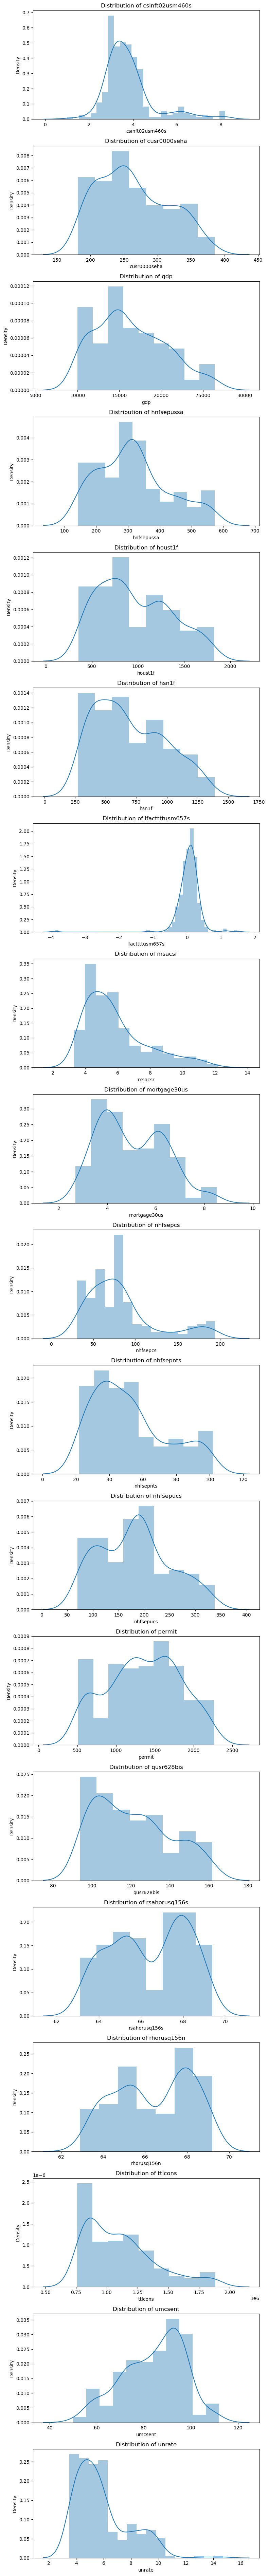

In [48]:
selected_columns = df.columns[2:]
fig, axes = plt.subplots(nrows=len(selected_columns), ncols=1, figsize=(8, 4 * len(selected_columns)))

for i, column in enumerate(selected_columns):
    sns.distplot(df[column], kde=True, ax=axes[i])
    axes[i].set_title(f'Distribution of {column}')

plt.tight_layout()
plt.show()

### Features vs Target

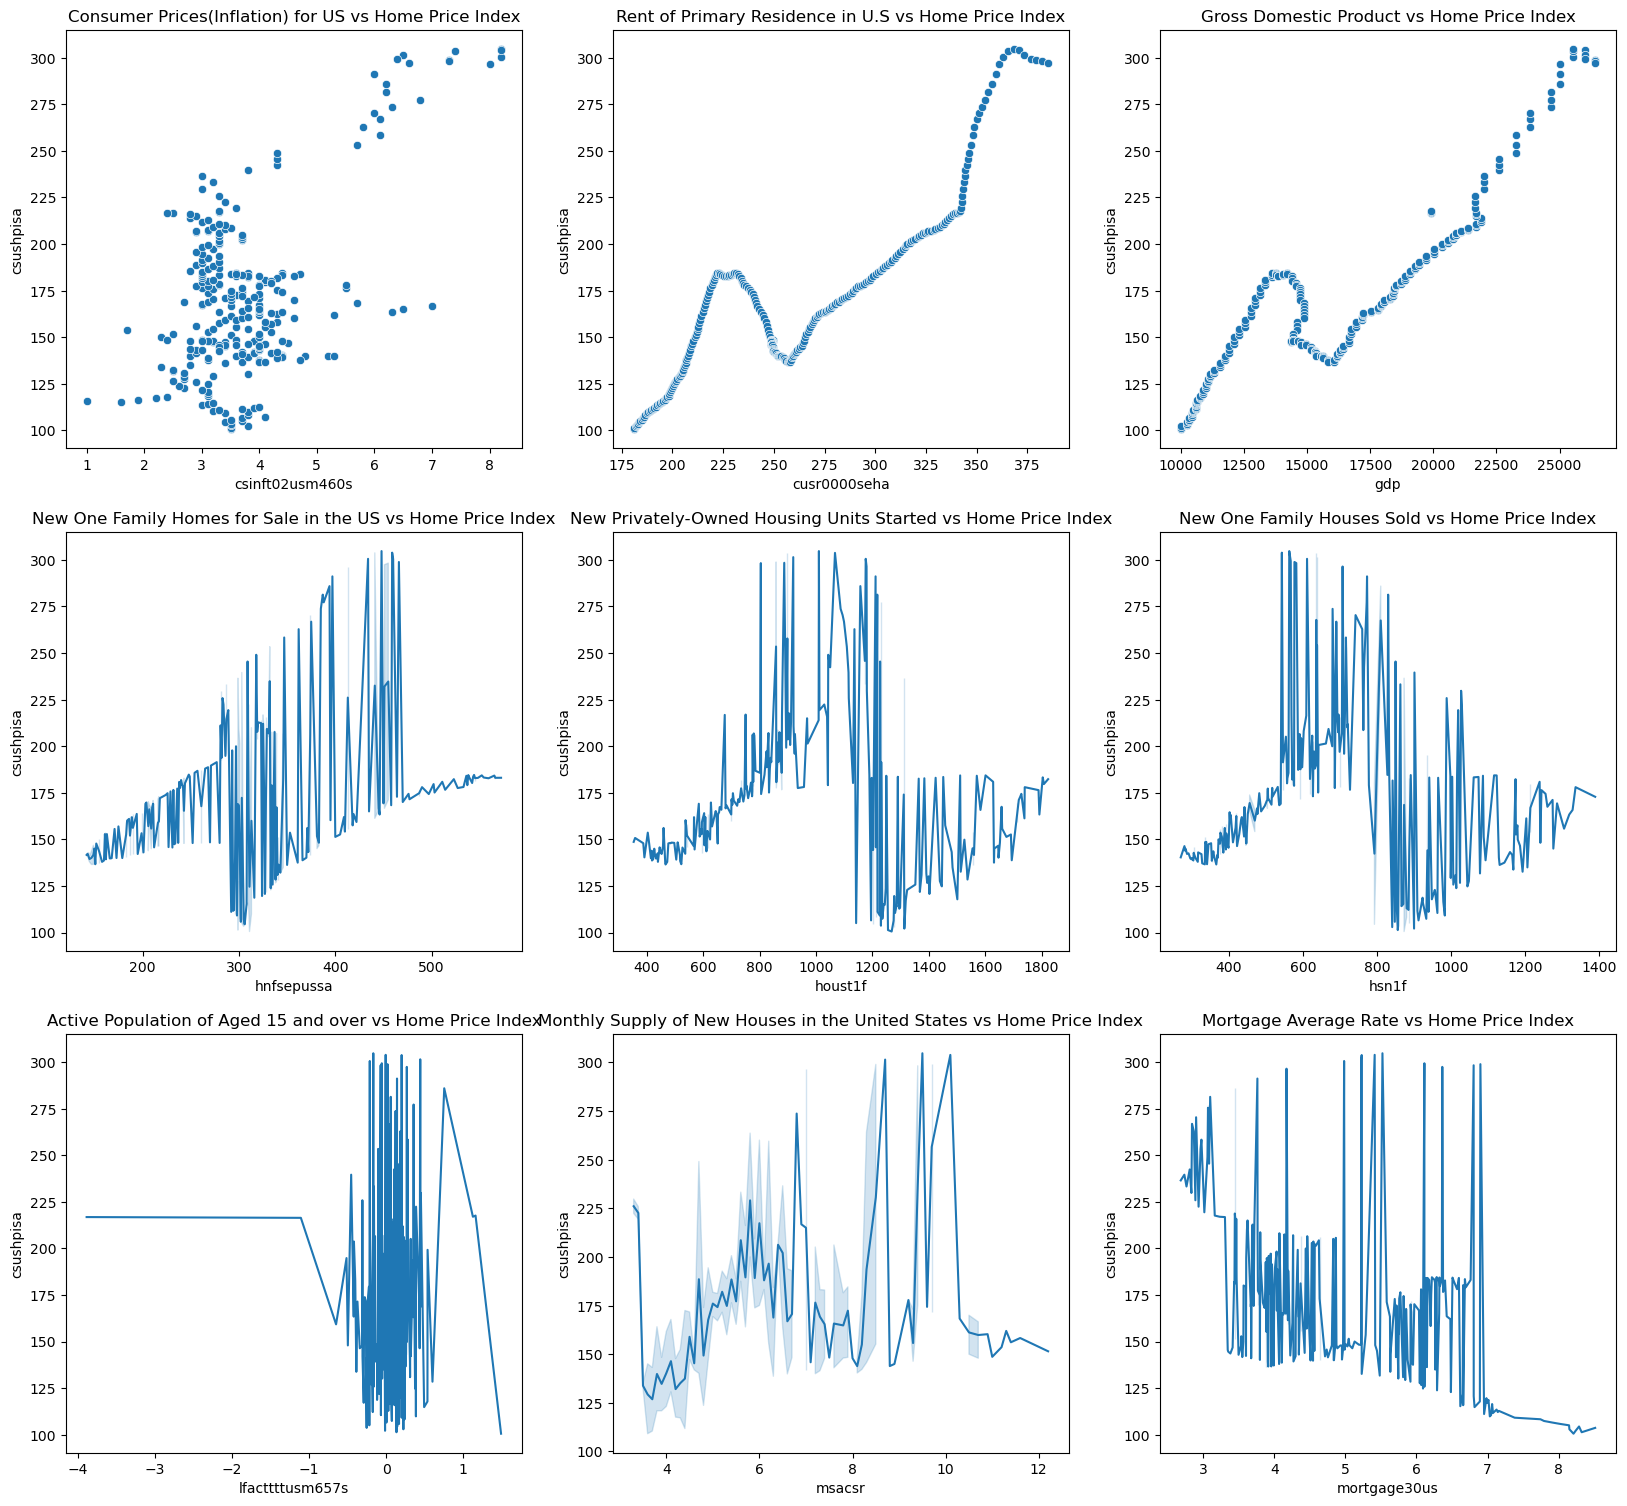

In [20]:
plt.figure(figsize=(20, 25))
plt.subplot(431)
sns.scatterplot(x=df['csinft02usm460s'],y=df['csushpisa'])
plt.title('Consumer Prices(Inflation) for US vs Home Price Index')

plt.subplot(432)
sns.scatterplot(x=df['cusr0000seha'],y=df['csushpisa'])
plt.title('Rent of Primary Residence in U.S vs Home Price Index')

plt.subplot(433)
sns.scatterplot(x=df['gdp'],y=df['csushpisa'])
plt.title('Gross Domestic Product vs Home Price Index')

plt.subplot(434)
sns.lineplot(x=df['hnfsepussa'],y=df['csushpisa'])
plt.title('New One Family Homes for Sale in the US vs Home Price Index')

plt.subplot(435)
sns.lineplot(x=df['houst1f'],y=df['csushpisa'])
plt.title('New Privately-Owned Housing Units Started vs Home Price Index')

plt.subplot(436)
sns.lineplot(x=df['hsn1f'],y=df['csushpisa'])
plt.title('New One Family Houses Sold vs Home Price Index')

plt.subplot(437)
sns.lineplot(x=df['lfacttttusm657s'],y=df['csushpisa'])
plt.title('Active Population of Aged 15 and over vs Home Price Index')

plt.subplot(438)
sns.lineplot(x=df['msacsr'],y=df['csushpisa'])
plt.title('Monthly Supply of New Houses in the United States vs Home Price Index')

plt.subplot(439)
sns.lineplot(x=df['mortgage30us'],y=df['csushpisa'])
plt.title('Mortgage Average Rate vs Home Price Index')

plt.show()


from the above plots
 - for columns houst1f, hsn1f, lfacttttusm657s has no relation with csushpisa i.e target variable, so we can drop those columns
 - cusr0000seha and gdp has linear relation with csushpisa.

In [21]:
df.drop(columns=['houst1f', 'hsn1f', 'lfacttttusm657s'], inplace=True)

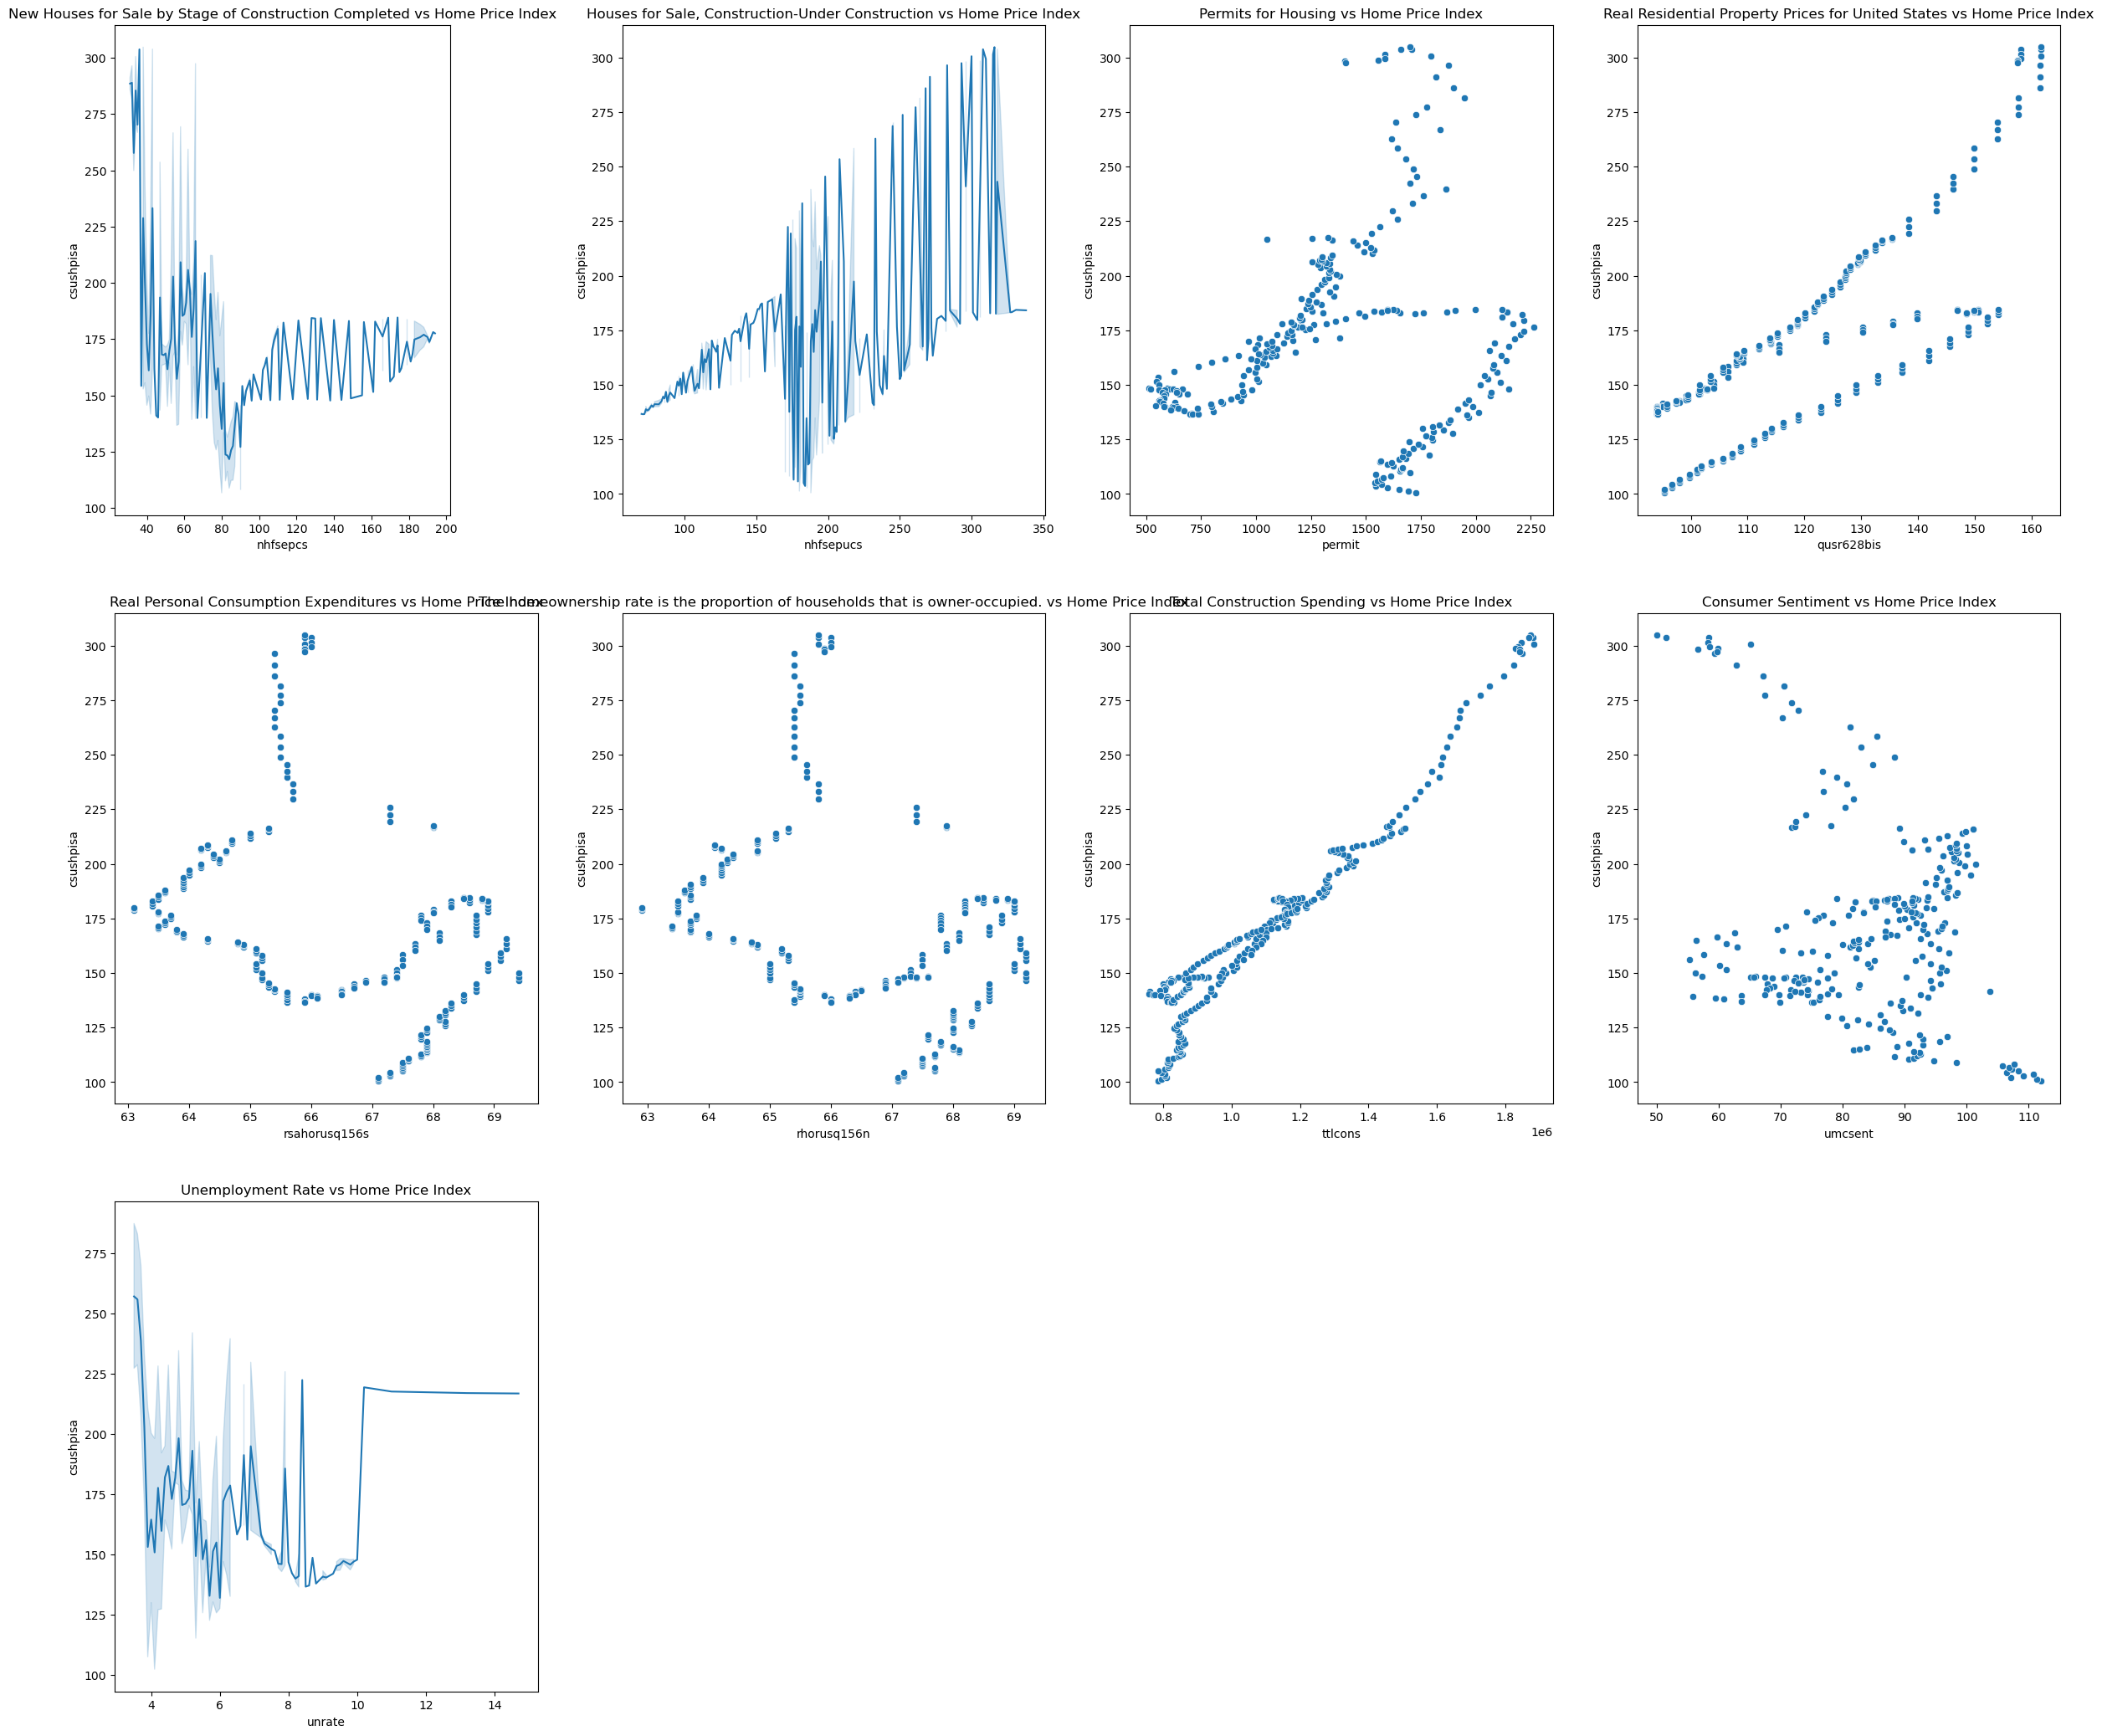

In [22]:
plt.figure(figsize=(30, 35))

plt.subplot(441)
sns.lineplot(x=df['nhfsepnts'],y=df['csushpisa'])
plt.title('Houses for Sale, Construction-Not Started vs Home Price Index')

plt.subplot(442)
sns.lineplot(x=df['nhfsepucs'],y=df['csushpisa'])
plt.title('Houses for Sale, Construction-Under Construction vs Home Price Index')

plt.subplot(443)
sns.scatterplot(x=df['permit'],y=df['csushpisa'])
plt.title('Permits for Housing vs Home Price Index')

plt.subplot(444)
sns.scatterplot(x=df['qusr628bis'],y=df['csushpisa'])
plt.title('Real Residential Property Prices for United States vs Home Price Index')

plt.subplot(445)
sns.scatterplot(x=df['rsahorusq156s'],y=df['csushpisa'])
plt.title('Real Personal Consumption Expenditures vs Home Price Index')

plt.subplot(446)
sns.scatterplot(x=df['rhorusq156n'],y=df['csushpisa'])
plt.title('The homeownership rate is the proportion of households that is owner-occupied. vs Home Price Index')

plt.subplot(447)
sns.scatterplot(x=df['ttlcons'],y=df['csushpisa'])
plt.title('Total Construction Spending vs Home Price Index')

plt.subplot(448)
sns.scatterplot(x=df['umcsent'],y=df['csushpisa'])
plt.title('Consumer Sentiment vs Home Price Index')

plt.subplot(449)
sns.lineplot(x=df['unrate'],y=df['csushpisa'])
plt.title('Unemployment Rate vs Home Price Index')

plt.subplot(451)
sns.lineplot(x=df['nhfsepcs'],y=df['csushpisa'])
plt.title('New Houses for Sale by Stage of Construction Completed vs Home Price Index')


plt.show()

- permit, nhfsepcs has no relationship with csushpisa so we can drop them
- ttlcons, qusr628bis has linear relationship with csushpisa

In [23]:
df.drop(columns=['qusr628bis','nhfsepcs'], inplace=True)

In [24]:
df.columns

Index(['date', 'csushpisa', 'csinft02usm460s', 'cusr0000seha', 'gdp',
       'hnfsepussa', 'msacsr', 'mortgage30us', 'nhfsepnts', 'nhfsepucs',
       'permit', 'rsahorusq156s', 'rhorusq156n', 'ttlcons', 'umcsent',
       'unrate'],
      dtype='object')

In [25]:
df.shape

(276, 16)

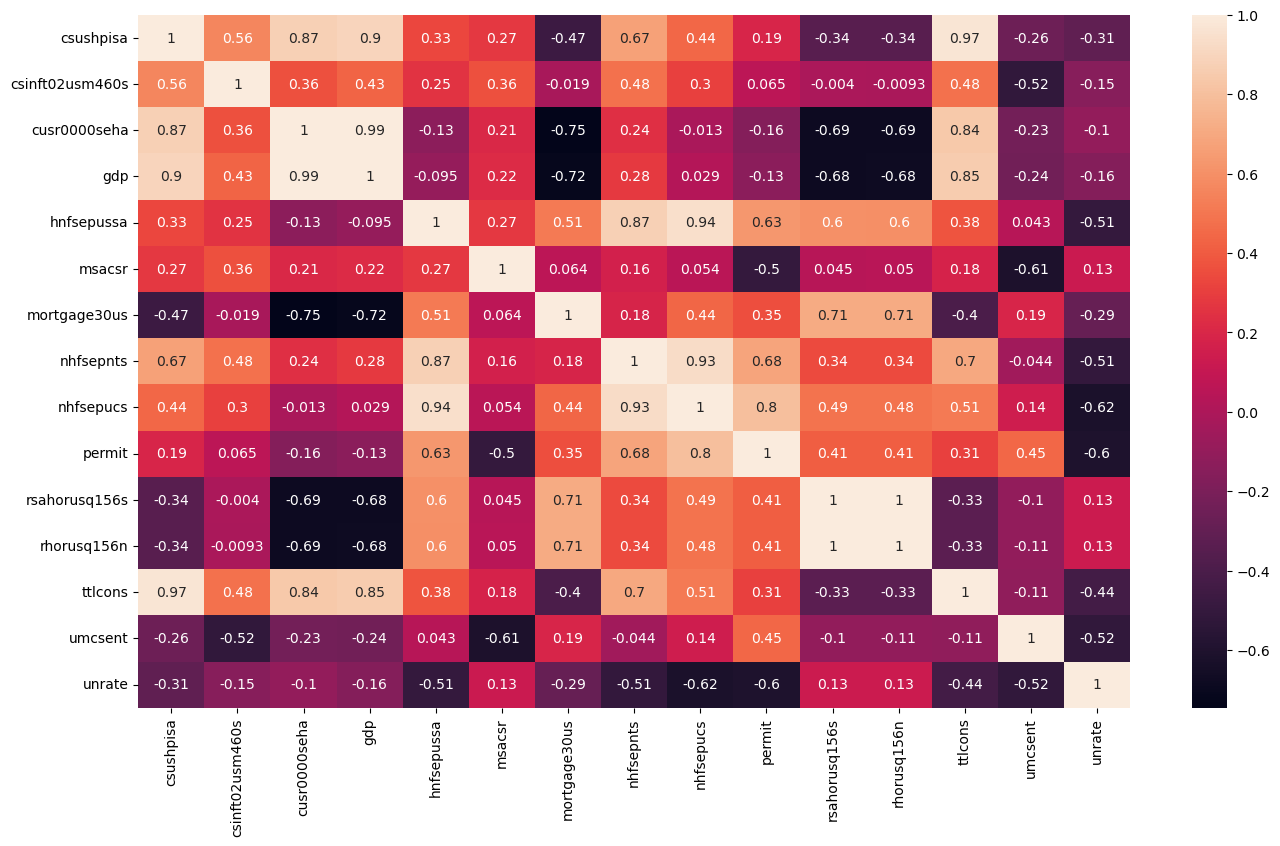

In [26]:
plt.figure(figsize=(16,9))
sns.heatmap(df.corr(),annot=True)
plt.show()

# Splitting the data into train and test

In [27]:
x = df.drop(columns=['csushpisa','date'], axis=1)
y = df['csushpisa']

In [85]:
x.head()

,csinft02usm460s,cusr0000seha,gdp,hnfsepussa,msacsr,mortgage30us,nhfsepnts,nhfsepucs,permit,rsahorusq156s,rhorusq156n,ttlcons,umcsent,unrate
0,3.5,180.9,10002.179,311.0,4.3,8.2100,41.0,188.0,1727.0,67.1,67.1,784940.0,112.0,4.0
1,3.5,181.3,10002.179,299.0,4.3,8.3250,40.0,180.0,1692.0,67.1,67.1,793737.0,111.3,4.1
2,3.8,181.9,10002.179,313.0,4.3,8.2400,42.0,185.0,1651.0,67.1,67.1,809459.0,107.1,4.0
3,3.5,182.3,10247.720,305.0,4.4,8.1525,40.0,185.0,1597.0,67.3,67.2,804766.0,109.2,3.8
4,3.5,182.8,10247.720,305.0,4.4,8.5150,37.0,184.0,1543.0,67.3,67.2,805005.0,110.7,4.0


In [86]:
y

0      100.551
1      101.339
2      102.127
3      102.922
4      103.678
        ...   
271    301.473
272    299.353
273    298.873
274    298.269
275    297.413
Name: csushpisa, Length: 276, dtype: float64

In [28]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Building the model

## 1. Linear Regression

In [29]:
lin_reg = LinearRegression()
lin_reg.fit(x_train, y_train)

LinearRegression()

In [30]:
linear_pred = lin_reg.predict(x_test)

In [31]:
lin_reg.score(x_test, y_test)

0.9943259653199448

In [35]:
cross_val_linear_model=cross_val_score(lin_reg,x_train,y_train,cv=10).mean()
cross_val_linear_model

0.9938287355682405

## 2. Decision Tree

### Find best depth

In [36]:
max_depth = np.arange(1, 21)
cross_val_dt=[]
for d in max_depth:
    dt_regressor= DecisionTreeRegressor(max_depth=d, random_state=0)
    dt_regressor.fit(x_train,y_train)
    print("Depth : ", d,  "cross_val_score : ", cross_val_score(dt_regressor,x_test,y_test,cv = 10).mean())
    cross_val_dt.append(cross_val_score(dt_regressor,x_test,y_test,cv = 10).mean())


Depth :  1 cross_val_score :  0.39956591964221966
Depth :  2 cross_val_score :  0.8608103359600756
Depth :  3 cross_val_score :  0.9387964778112738
Depth :  4 cross_val_score :  0.9218994298184515
Depth :  5 cross_val_score :  0.9370655848930209
Depth :  6 cross_val_score :  0.9491013904950002
Depth :  7 cross_val_score :  0.9657645928606027
Depth :  8 cross_val_score :  0.966957797308418
Depth :  9 cross_val_score :  0.9646364197895956
Depth :  10 cross_val_score :  0.9598457619124524
Depth :  11 cross_val_score :  0.9628475686824476
Depth :  12 cross_val_score :  0.9628475686824476
Depth :  13 cross_val_score :  0.9628475686824476
Depth :  14 cross_val_score :  0.9628475686824476
Depth :  15 cross_val_score :  0.9628475686824476
Depth :  16 cross_val_score :  0.9628475686824476
Depth :  17 cross_val_score :  0.9628475686824476
Depth :  18 cross_val_score :  0.9628475686824476
Depth :  19 cross_val_score :  0.9628475686824476
Depth :  20 cross_val_score :  0.9628475686824476


In [37]:
cross_val_dt_regressor=max(cross_val_dt)

In [38]:
print("The best depth is 8 and Cross_val_score is:",cross_val_dt_regressor)

The best depth is 8 and Cross_val_score is: 0.966957797308418


### Implementing Decision Tree Regressor

In [39]:
dt_regressor= DecisionTreeRegressor(max_depth=8, random_state=0)
dt_regressor.fit(x_train,y_train)

DecisionTreeRegressor(max_depth=8, random_state=0)

In [40]:
dt_pred = dt_regressor.predict(x_test)

In [41]:
cross_val_dt_regressor = cross_val_score(dt_regressor,x_test,y_test,cv = 10).mean()
cross_val_dt_regressor

0.966957797308418

In [42]:
ftImp = list(zip(dt_regressor.feature_importances_, df.columns[:-1]))
imp = pd.DataFrame(ftImp, columns = ["Importance","Feature"])
imp.sort_values("Importance",ascending = False,inplace=True)
imp

,Importance,Feature
11,0.922360,rsahorusq156s
1,0.061179,csushpisa
7,0.012211,mortgage30us
6,0.000914,msacsr
2,0.000856,csinft02usm460s
13,0.000780,ttlcons
5,0.000605,hnfsepussa
10,0.000381,permit
12,0.000275,rhorusq156n
3,0.000264,cusr0000seha


## 3. Random Forest

### finding the best max_depth

In [43]:
max_depth=np.array([2,4,8,10,11,12,13,15,18,20,22,24,26,28,30])
cross_val_rf=[]
for d in max_depth:
    rf_regressor= RandomForestRegressor(max_depth=d, random_state=0)
    rf_regressor.fit(x_train,y_train)
    print("Depth : ", d,  "cross_val_score : ", cross_val_score(rf_regressor,x_test,y_test,cv = 15).mean())
    cross_val_rf.append(cross_val_score(rf_regressor,x_test,y_test,cv = 15).mean())

Depth :  2 cross_val_score :  0.8278014755726326
Depth :  4 cross_val_score :  0.9471506709732901
Depth :  8 cross_val_score :  0.9596142320312292
Depth :  10 cross_val_score :  0.9585684486087468
Depth :  11 cross_val_score :  0.9589133380166508
Depth :  12 cross_val_score :  0.9589133380166508
Depth :  13 cross_val_score :  0.9589133380166508
Depth :  15 cross_val_score :  0.9589133380166508
Depth :  18 cross_val_score :  0.9589133380166508
Depth :  20 cross_val_score :  0.9589133380166508
Depth :  22 cross_val_score :  0.9589133380166508
Depth :  24 cross_val_score :  0.9589133380166508
Depth :  26 cross_val_score :  0.9589133380166508
Depth :  28 cross_val_score :  0.9589133380166508
Depth :  30 cross_val_score :  0.9589133380166508


In [44]:
cross_val_rf_regressor=max(cross_val_rf)

In [45]:
print("The best depth is 8 and Cross_val_score is:",cross_val_rf_regressor)

The best depth is 8 and Cross_val_score is: 0.9596142320312292


### Implementing Random Forest Regressor

In [46]:
rf_regressor= RandomForestRegressor(max_depth=8, random_state=0)
rf_regressor.fit(x_train,y_train)

RandomForestRegressor(max_depth=8, random_state=0)

In [47]:
rf_pred = rf_regressor.predict(x_test)

In [48]:
cross_val_rf_regressor = cross_val_score(rf_regressor,x_test,y_test,cv = 15).mean()
cross_val_rf_regressor

0.9596142320312292

## Extreme Gradient Boosting Regression

###  Choosing the best Learning Rate

In [49]:
cross_val_xgb=[]
for lr in [0.01,0.05,0.08,0.1,0.2,0.25,0.3]:
    xgb_regressor=xgb.XGBRegressor(learning_rate=lr,n_estimators=100) 
    xgb_regressor.fit(x_train,y_train) 
    print("Learning rate : ", lr, "cross_val_score : ", cross_val_score(xgb_regressor,x_test,y_test,cv = 15).mean())
    cross_val_xgb.append(cross_val_score(xgb_regressor,x_test,y_test,cv = 15).mean())

Learning rate :  0.01 cross_val_score :  0.5462824157260685
Learning rate :  0.05 cross_val_score :  0.954643000964555
Learning rate :  0.08 cross_val_score :  0.9512266414507978
Learning rate :  0.1 cross_val_score :  0.9543519345720936
Learning rate :  0.2 cross_val_score :  0.9541929703791593
Learning rate :  0.25 cross_val_score :  0.9577105626423227
Learning rate :  0.3 cross_val_score :  0.952958483605867


In [50]:
cross_val_xgb_regressor=max(cross_val_xgb)

In [51]:
print("The best Learning rate is 0.25 and Cross_val_score is:",cross_val_xgb_regressor)


The best Learning rate is 0.25 and Cross_val_score is: 0.9577105626423227


### Implementing Extreme Gradient Boosting Regression

In [52]:
xgb_regressor= xgb.XGBRegressor(learning_rate =0.1,n_estimators=100) 
xgb_regressor.fit(x_train,y_train) 

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [53]:
xgb_pred = xgb_regressor.predict(x_test)

In [54]:
cross_val_xgb_regressor = cross_val_score(xgb_regressor,x_test,y_test,cv = 15).mean()
cross_val_xgb_regressor

0.9543519345720936

## Cross-Validation Score for all Models

In [55]:
print("Cross Validation Score for Linear Regression Model:",cross_val_linear_model)
print("Cross Validation Score for Decision Tree Regression Model: ",cross_val_dt_regressor)
print("Cross Validation Score for Random Forest Regression Model: ",cross_val_rf_regressor)
print("Cross Validation Score for Extreme-Gradient Boosting Regression Model: ",cross_val_xgb_regressor)

Cross Validation Score for Linear Regression Model: 0.9938287355682405
Cross Validation Score for Decision Tree Regression Model:  0.966957797308418
Cross Validation Score for Random Forest Regression Model:  0.9596142320312292
Cross Validation Score for Extreme-Gradient Boosting Regression Model:  0.9543519345720936


##  R2 Score for Machine-Learning Models

In [57]:
R2_score_lr=r2_score(y_test,linear_pred)
R2_score_dt=r2_score(y_test,dt_pred)
R2_score_rf=r2_score(y_test,rf_pred)
R2_score_xgb=r2_score(y_test,xgb_pred)

In [58]:
print("R2 Score for Linear Regression Model:",R2_score_lr)
print("R2 Score for Decision Tree Regression Model: ",R2_score_dt)
print("R2 Score for Random Forest Regression Model: ",R2_score_rf)
print("R2 Score for Extreme-Gradient Boosting Regression Model: ",R2_score_xgb)

R2 Score for Linear Regression Model: 0.9943259653199448
R2 Score for Decision Tree Regression Model:  0.9962606025160494
R2 Score for Random Forest Regression Model:  0.9986562612204499
R2 Score for Extreme-Gradient Boosting Regression Model:  0.9958943969978579


#### From this we can say that Random Forest Regression Model is the best model